In [1]:
from __future__ import print_function, division
import numpy as np
from glob import glob
import pandas as pd
import os
from tqdm import tqdm
output_path = os.path.join('..','input')
import matplotlib.pyplot as plt
from skimage.util._montage import montage
from skimage.color import label2rgb
%matplotlib inline

In [2]:
import h5py
with h5py.File('all_patches.hdf5') as luna_h5:
    all_slices = luna_h5['ct_slices'].value
    all_classes = luna_h5['slice_class'].value
    print('data', all_slices.shape, 'classes', all_classes.shape)

D:\ProgramData\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


data (6691, 64, 64) classes (6691, 1)


Text(0.5, 1.0, 'Benign Tiles')

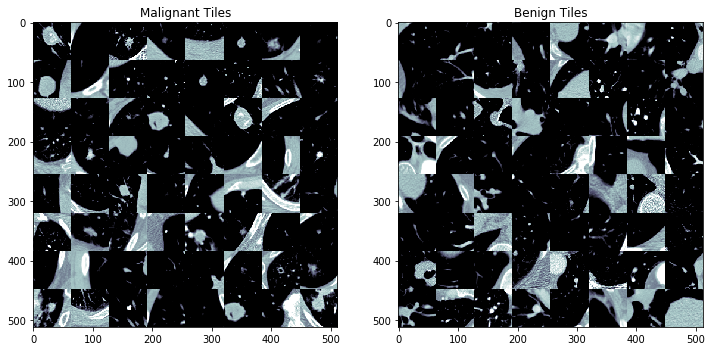

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12, 6))
plt_args = dict(cmap = 'bone', vmin = -600, vmax = 300)
ax1.imshow(montage(all_slices[np.random.choice(np.where(all_classes>0.5)[0],size = 64)]), **plt_args)
ax1.set_title('Malignant Tiles')
ax2.imshow(montage(all_slices[np.random.choice(np.where(all_classes<0.5)[0],size = 64)]), **plt_args)
ax2.set_title('Benign Tiles')

In [4]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils

sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(input_tensor=None, input_shape=None,
               weights='imagenet',
               classes=1000,
              use_bn_on_input = False, # to avoid preprocessing
               first_stride = 2
              ):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if input_tensor is None:
        raw_img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if use_bn_on_input:
        img_input = BatchNormalization()(raw_img_input)
    else:
        img_input = raw_img_input


    x = Convolution2D(64, (3, 3), strides=(first_stride, first_stride), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    out = Activation('softmax', name='loss')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = raw_img_input

    model = Model(inputs, out, name='squeezenet')

    # load weights
    if weights == 'imagenet':

        weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

Using TensorFlow backend.


In [5]:
import keras
lung_node_cnn = SqueezeNet(input_shape = (64, 64, 1), 
                           weights = None, classes = 2,
                  use_bn_on_input = True)
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
lung_node_cnn.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
loss_history = []
lung_node_cnn.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 31, 31, 64)   640         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 31, 31, 64)   0           conv1[0][0]                      
_________________________________________________________________________________________

__________________________________________________________________________________________________
fire6/expand3x3 (Conv2D)        (None, 3, 3, 192)    83136       fire6/relu_squeeze1x1[0][0]      
__________________________________________________________________________________________________
fire6/relu_expand1x1 (Activatio (None, 3, 3, 192)    0           fire6/expand1x1[0][0]            
__________________________________________________________________________________________________
fire6/relu_expand3x3 (Activatio (None, 3, 3, 192)    0           fire6/expand3x3[0][0]            
__________________________________________________________________________________________________
fire6/concat (Concatenate)      (None, 3, 3, 384)    0           fire6/relu_expand1x1[0][0]       
                                                                 fire6/relu_expand3x3[0][0]       
__________________________________________________________________________________________________
fire7/sque

In [6]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
X_vec = (np.expand_dims(all_slices,-1) - np.mean(all_slices))/np.std(all_slices)

y_vec = to_categorical(all_classes)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, 
                                                   train_size = 0.75,
                                                   random_state = 1, 
                                                   stratify = all_classes)

In [7]:
from sklearn.metrics import classification_report
y_pred_proba = lung_node_cnn.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(np.argmax(y_test,1),
                      y_pred))


              precision    recall  f1-score   support

           0       0.63      0.86      0.73      1041
           1       0.42      0.17      0.25       632

    accuracy                           0.60      1673
   macro avg       0.53      0.51      0.49      1673
weighted avg       0.55      0.60      0.55      1673



In [8]:
for i in range(5):
    loss_history += [lung_node_cnn.fit(X_train, y_train, 
              validation_data=(X_test, y_test),
                               shuffle = True,
                               batch_size = 32,
                               epochs = 1)]

Train on 5018 samples, validate on 1673 samples
Epoch 1/1
5018/5018 [==============================] - ETA: 2:14 - loss: 0.6931 - accuracy: 0.43 - ETA: 1:16 - loss: 0.6929 - accuracy: 0.56 - ETA: 56s - loss: 0.6929 - accuracy: 0.5521 - ETA: 47s - loss: 0.6925 - accuracy: 0.578 - ETA: 41s - loss: 0.6919 - accuracy: 0.606 - ETA: 37s - loss: 0.6908 - accuracy: 0.635 - ETA: 34s - loss: 0.6908 - accuracy: 0.625 - ETA: 32s - loss: 0.6897 - accuracy: 0.636 - ETA: 30s - loss: 0.6885 - accuracy: 0.642 - ETA: 29s - loss: 0.6876 - accuracy: 0.640 - ETA: 27s - loss: 0.6878 - accuracy: 0.633 - ETA: 26s - loss: 0.6867 - accuracy: 0.632 - ETA: 25s - loss: 0.6859 - accuracy: 0.629 - ETA: 25s - loss: 0.6859 - accuracy: 0.625 - ETA: 24s - loss: 0.6864 - accuracy: 0.620 - ETA: 23s - loss: 0.6861 - accuracy: 0.619 - ETA: 23s - loss: 0.6844 - accuracy: 0.621 - ETA: 22s - loss: 0.6838 - accuracy: 0.621 - ETA: 22s - loss: 0.6816 - accuracy: 0.625 - ETA: 21s - loss: 0.6809 - accuracy: 0.625 - ETA: 21s - loss:

5018/5018 [==============================] - ETA: 17s - loss: 0.6683 - accuracy: 0.593 - ETA: 17s - loss: 0.6539 - accuracy: 0.625 - ETA: 17s - loss: 0.6539 - accuracy: 0.625 - ETA: 17s - loss: 0.6636 - accuracy: 0.609 - ETA: 17s - loss: 0.6473 - accuracy: 0.643 - ETA: 17s - loss: 0.6538 - accuracy: 0.630 - ETA: 17s - loss: 0.6614 - accuracy: 0.616 - ETA: 17s - loss: 0.6580 - accuracy: 0.625 - ETA: 17s - loss: 0.6580 - accuracy: 0.625 - ETA: 17s - loss: 0.6641 - accuracy: 0.615 - ETA: 17s - loss: 0.6646 - accuracy: 0.613 - ETA: 17s - loss: 0.6634 - accuracy: 0.617 - ETA: 17s - loss: 0.6601 - accuracy: 0.625 - ETA: 16s - loss: 0.6624 - accuracy: 0.618 - ETA: 16s - loss: 0.6599 - accuracy: 0.622 - ETA: 16s - loss: 0.6590 - accuracy: 0.625 - ETA: 16s - loss: 0.6569 - accuracy: 0.628 - ETA: 16s - loss: 0.6538 - accuracy: 0.633 - ETA: 16s - loss: 0.6566 - accuracy: 0.629 - ETA: 16s - loss: 0.6556 - accuracy: 0.631 - ETA: 16s - loss: 0.6557 - accuracy: 0.631 - ETA: 16s - loss: 0.6544 - accur

5018/5018 [==============================] - ETA: 17s - loss: 0.6812 - accuracy: 0.562 - ETA: 17s - loss: 0.6481 - accuracy: 0.640 - ETA: 17s - loss: 0.6434 - accuracy: 0.625 - ETA: 17s - loss: 0.6531 - accuracy: 0.609 - ETA: 17s - loss: 0.6595 - accuracy: 0.587 - ETA: 17s - loss: 0.6575 - accuracy: 0.588 - ETA: 17s - loss: 0.6605 - accuracy: 0.598 - ETA: 17s - loss: 0.6558 - accuracy: 0.601 - ETA: 17s - loss: 0.6496 - accuracy: 0.607 - ETA: 17s - loss: 0.6557 - accuracy: 0.596 - ETA: 17s - loss: 0.6553 - accuracy: 0.593 - ETA: 17s - loss: 0.6535 - accuracy: 0.599 - ETA: 17s - loss: 0.6561 - accuracy: 0.598 - ETA: 17s - loss: 0.6548 - accuracy: 0.602 - ETA: 17s - loss: 0.6524 - accuracy: 0.608 - ETA: 17s - loss: 0.6498 - accuracy: 0.609 - ETA: 17s - loss: 0.6513 - accuracy: 0.606 - ETA: 17s - loss: 0.6493 - accuracy: 0.607 - ETA: 17s - loss: 0.6482 - accuracy: 0.610 - ETA: 17s - loss: 0.6492 - accuracy: 0.609 - ETA: 17s - loss: 0.6489 - accuracy: 0.610 - ETA: 17s - loss: 0.6457 - accur

5018/5018 [==============================] - ETA: 17s - loss: 0.6101 - accuracy: 0.718 - ETA: 17s - loss: 0.5892 - accuracy: 0.718 - ETA: 17s - loss: 0.6446 - accuracy: 0.645 - ETA: 17s - loss: 0.6485 - accuracy: 0.609 - ETA: 17s - loss: 0.6526 - accuracy: 0.587 - ETA: 17s - loss: 0.6521 - accuracy: 0.593 - ETA: 17s - loss: 0.6445 - accuracy: 0.602 - ETA: 17s - loss: 0.6384 - accuracy: 0.593 - ETA: 17s - loss: 0.6316 - accuracy: 0.600 - ETA: 17s - loss: 0.6287 - accuracy: 0.606 - ETA: 17s - loss: 0.6405 - accuracy: 0.588 - ETA: 16s - loss: 0.6413 - accuracy: 0.593 - ETA: 16s - loss: 0.6408 - accuracy: 0.601 - ETA: 16s - loss: 0.6428 - accuracy: 0.596 - ETA: 16s - loss: 0.6406 - accuracy: 0.593 - ETA: 16s - loss: 0.6448 - accuracy: 0.597 - ETA: 16s - loss: 0.6433 - accuracy: 0.599 - ETA: 16s - loss: 0.6385 - accuracy: 0.605 - ETA: 16s - loss: 0.6347 - accuracy: 0.610 - ETA: 16s - loss: 0.6365 - accuracy: 0.606 - ETA: 16s - loss: 0.6392 - accuracy: 0.605 - ETA: 15s - loss: 0.6421 - accur

5018/5018 [==============================] - ETA: 17s - loss: 0.6275 - accuracy: 0.687 - ETA: 17s - loss: 0.6666 - accuracy: 0.625 - ETA: 17s - loss: 0.6521 - accuracy: 0.656 - ETA: 17s - loss: 0.6628 - accuracy: 0.640 - ETA: 17s - loss: 0.6451 - accuracy: 0.662 - ETA: 17s - loss: 0.6456 - accuracy: 0.651 - ETA: 17s - loss: 0.6493 - accuracy: 0.647 - ETA: 16s - loss: 0.6477 - accuracy: 0.636 - ETA: 16s - loss: 0.6535 - accuracy: 0.645 - ETA: 16s - loss: 0.6531 - accuracy: 0.640 - ETA: 16s - loss: 0.6529 - accuracy: 0.647 - ETA: 16s - loss: 0.6441 - accuracy: 0.658 - ETA: 16s - loss: 0.6388 - accuracy: 0.665 - ETA: 16s - loss: 0.6452 - accuracy: 0.651 - ETA: 16s - loss: 0.6437 - accuracy: 0.647 - ETA: 16s - loss: 0.6434 - accuracy: 0.644 - ETA: 15s - loss: 0.6437 - accuracy: 0.647 - ETA: 15s - loss: 0.6474 - accuracy: 0.637 - ETA: 15s - loss: 0.6468 - accuracy: 0.639 - ETA: 15s - loss: 0.6461 - accuracy: 0.637 - ETA: 15s - loss: 0.6464 - accuracy: 0.641 - ETA: 15s - loss: 0.6429 - accur

Text(0.5, 1.0, 'Accuracy')

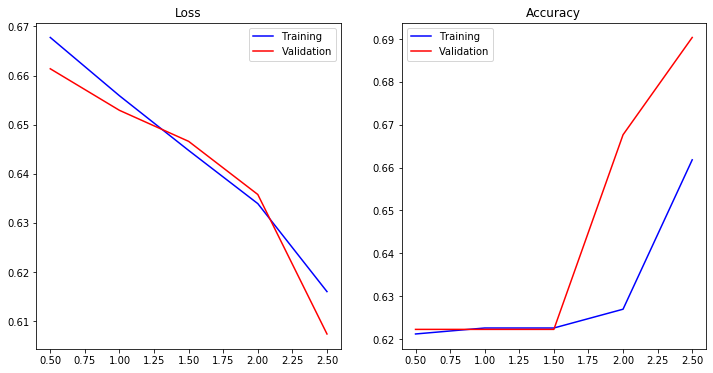

In [9]:
epich = np.cumsum(np.concatenate(
    [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate(
        [mh.history['val_loss'] for mh in loss_history]), 'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate(
    [mh.history['accuracy'] for mh in loss_history]), 'b-',
                 epich, np.concatenate(
        [mh.history['val_accuracy'] for mh in loss_history]),
                 'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Accuracy')

In [10]:
from sklearn.metrics import classification_report
y_pred_proba = lung_node_cnn.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(np.argmax(y_test,1),
                      y_pred))


              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1041
           1       0.58      0.62      0.60       632

    accuracy                           0.69      1673
   macro avg       0.67      0.68      0.67      1673
weighted avg       0.69      0.69      0.69      1673



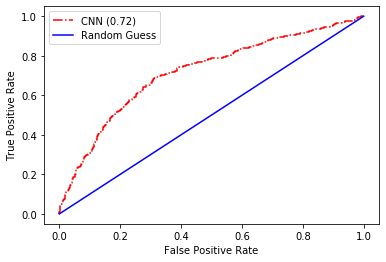

In [11]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), y_pred_proba[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()